<a href="https://colab.research.google.com/github/KatHaruto/PINNs_example/blob/main/SFHCPINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

difference between $SFHCPINN_{NN}$ and $SFHCPINN$ is whether distance function adn extension functino are numerically determined , or computed using NN that trained before PINNs training.

In [17]:
import sys
sys.version

'3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]'

In [18]:
from functools import partial
from typing import Literal,TypeAlias, Protocol # type alias statement requires Python 3.12 or newer
import warnings

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from scipy.stats import qmc


In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [20]:


SAMPLING_STRATEGY: TypeAlias = Literal["uniform", "LHS", "Sobol"] # todo: "adaptive"


In [21]:
class Sin(nn.Module):
  def __init__(self):
    super(Sin, self).__init__()
  def forward(self, x):
    return torch.sin(x)

class FourierFeatureLayer(nn.Module):
    def __init__(self,input_dim, hidden_size, k):
      super(FourierFeatureLayer, self).__init__()
      self.k = k
      self.w = nn.Linear(input_dim, hidden_size)

    def forward(self, x):
      x = self.w(self.k * x)
      return torch.cat([torch.cos(x), torch.sin(x)] , dim=1)

class PINN(nn.Module):
  def __init__(self, *, input_dim, output_dim, hidden_size_list):
    super(PINN, self).__init__()
    layers = []

    for hidden_size in hidden_size_list:
        layers.append(nn.Linear(input_dim, hidden_size))
        layers.append(Sin())
        input_dim = hidden_size
    layers.append(nn.Linear(input_dim, output_dim))

    self.layers = nn.Sequential(*layers)



  def forward(self, x):
    return self.layers(x)


class SFPINN(nn.Module):
  def __init__(self, input_dim, output_dim,  subn_hidden_size_list: list[list[int]], frequencies: list[int]):
    super(SFPINN, self).__init__()
    if len(subn_hidden_size_list) != len(frequencies):
      raise ValueError("subn_hidden_size_list and frequencies must have the same length")

    self.subnetworks = nn.ModuleList(
        [
            nn.Sequential(
              FourierFeatureLayer(
                  input_dim,
                  hidden_size_list[0],
                  freq
              ),
              PINN(
                input_dim=hidden_size_list[0] * 2,
                output_dim=output_dim,
                hidden_size_list=hidden_size_list[1:]
              )
            )
            for hidden_size_list,freq in zip(subn_hidden_size_list, frequencies)
        ]
    )

    self.w = nn.Linear(output_dim * len(frequencies), output_dim)



  def forward(self, x):
    out = torch.cat([subn(x) for subn in self.subnetworks], dim=1)
    return self.w(out)

# one dimensional ADE

## Governing Equation
$$
\frac{\partial u(x,t)}{\partial t}  = \tilde{p} \frac{\partial^2u(x,t)}{\partial t} - \tilde{q} \frac{\partial u(x,t)}{\partial x} + f(x,t), for\,x \in [a,b]\, and\, t \in [t_0,T]
$$

### I/C and B/C
$$
u(x,t_0) = A_0(x), \\
u(a,t) = A_1(t), \\
u(b,t) = A_2(t), \\
\frac{\partial u(a,t)}{\partial x} = N_1(t), \\
\frac{\partial u(b,t)}{\partial x} = N_2(t)
$$

### Solution is folloing equation
$$
u(x,t) =  e^{-\alpha t}[sin(\pi x) + 0.1 sin(\beta \pi x)]
$$

In [22]:
p_hat = 0.02
q_hat = 0.01

Omega = (0., 2.)
T = (0.,5.)

alpha = 0.1
beta = 30

In [23]:
def U(xt):
  x,t = xt[:,0:1], xt[:,1:2]
  return torch.exp(-alpha * t) * (torch.sin(torch.pi * x) + 0.1 * torch.sin(beta * torch.pi * x))

def du_dt(xt):
  return -alpha * U(xt)

def du_dx(xt):
  x,t = xt[:,0:1], xt[:,1:2]
  return torch.exp(-alpha * t) * (torch.pi * torch.cos(torch.pi * x) + 0.1 * beta * torch.pi * torch.cos(beta * torch.pi * x))

def d2u_dx2(xt):
  x,t = xt[:,0:1], xt[:,1:2]
  return torch.exp(-alpha * t) * (- torch.pi**2 * torch.sin(torch.pi * x) - 0.1 * beta**2 * torch.pi**2 * torch.sin(beta * torch.pi * x))

def D(xt):
  x,t = xt[:,0:1], xt[:,1:2]
  return x * (2-x) * t / ( 5 * 2**2)

def G(xt):
  x,t = xt[:,0:1], xt[:,1:2]
  return torch.sin(torch.pi * x) + 0.1 * torch.sin(beta * torch.pi * x)

In [24]:
epoch = 50_000
N_r = 8_000

## SFHCPINN does not need initial/boundary points.
# N_b = 4_000
# N_i = 3_000

initial_lr = 0.01
decay_rate = 0.975
decay_step_size = 100

gamma_0 = 20




In [25]:
class Sampler(Protocol):
  def __init__(self,dim: int): ...
  def sample(self, boundary, num): ...

class UniformSampler:
  def __init__(self,dim):
    self.dim = dim
  def sample(self, boundary:list[list[int]], num:int):
    return np.random.uniform(size=(num, self.dim)) * (boundary[:,1] - boundary[:,0]) + boundary[:,0]

class LHSSampler:
  def __init__(self,dim):
    self.dim = dim
    self.sampler = qmc.LatinHypercube(d=dim)
  def sample(self, boundary:list[list[int]], num:int):
    return self.sampler.random(num) * (boundary[:,1] - boundary[:,0]) + boundary[:,0]

class SobolSampler:
  def __init__(self,dim):
    self.dim = dim
    self.sampler = qmc.Sobol(d=dim, scramble=True)

  def sample(self, boundary:list[list[int]], num:int):
    if not np.log2(num).is_integer():
      warnings.warn("number of samples should be power of 2")
    return self.sampler.random(num) * (boundary[:,1] - boundary[:,0]) + boundary[:,0]


In [26]:
def gen_sample(sampling_num:int, boundary: list, strategy: SAMPLING_STRATEGY):
  def _get_sampler(strategy: SAMPLING_STRATEGY, dim) -> Sampler:
    if strategy == "uniform":
      return UniformSampler(dim)
    if strategy == "LHS":
      return LHSSampler(dim)
    if strategy == "Sobol":
      return SobolSampler(dim)
    raise ValueError(f"Unknown sampling strategy: {strategy}")

  dim = len(boundary)
  return torch.from_numpy(_get_sampler(strategy, dim).sample(boundary, sampling_num)).to(torch.float)

In [27]:
def generate_collocation_data(N,boundary,gen_sample_func):
  return gen_sample_func(N,boundary)

In [28]:
def compute_penalty(gamma_0, current_epoch, total_epoch):
  if current_epoch < 0.1 * total_epoch:
    return gamma_0
  if current_epoch < 0.2 * total_epoch:
    return 10 * gamma_0
  if current_epoch < 0.25 * total_epoch:
    return 50 * gamma_0
  if current_epoch < 0.5 * total_epoch:
    return 100 * gamma_0
  if current_epoch < 0.75 * total_epoch:
    return 200 * gamma_0
  return 500 * gamma_0

In [61]:

loss_func = nn.MSELoss()
def train(model, boundary, pde_residual, optimizer, scheduler, epoch,sampling_stragtegy='uniform'):
  gen_sample_func = partial(gen_sample, strategy=sampling_stragtegy)
  losses = []
  for e in tqdm(range(epoch)):
    model.train()
    optimizer.zero_grad()

    xt = generate_collocation_data(N_r, boundary,gen_sample_func).to(device).requires_grad_(True)

    assert xt.size() == torch.Size([N_r, 2])
    out = model(xt)
    g = G(xt)
    d = D(xt)

    u =  g + d * out
    #print(f"u: {u.mean().item()} g: {g.mean().item()} d: {d.mean().item()}")
    res = pde_residual(u,xt,e)
    #print(f" res mean: {torch.mean(res).item()}, res sqaured mean: {torch.mean(torch.square(res)).item()}")
    # loss = loss_func(res, torch.zeros_like(res))
    loss = torch.mean(res ** 2)
    loss.backward()

    optimizer.step()
    scheduler.step()
    losses.append(loss.item())

    if e % 1000 == 0:

      with torch.no_grad():
        model.eval()
        test_xt = generate_collocation_data(10_000, boundary,gen_sample_func).to(device)
        test_out = model(test_xt)
        g = G(test_xt)
        d = D(test_xt)
        u_pred = g + d * test_out

        u_true = U(test_xt)
        mse = torch.mean((u_pred - u_true) ** 2)
        rel = ((u_pred - u_true)**2).sum() / (u_true ** 2).sum()

        print(f"epoch: {e}, learning_rate: {optimizer.param_groups[0]['lr']:.5f}, loss: {loss.item():.5f} MSE: {mse.item():.5f} REL: {rel.item():.5f}")
    if e % 3000 == 0:
      visualize(model)



  return losses




In [62]:
boundary = np.array([[0.,2.],[0.,5.]])


def source_fn(xt):
    return du_dt(xt) - p_hat * d2u_dx2(xt) + q_hat * du_dx(xt)

def pde_residual(u,X, current_epoch):
    #X_pde = X
    # X_pde = X.clone().detach().requires_grad_(True)
    grad_u = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True,retain_graph=True)[0]
    du_dx = grad_u[:,0:1]
    du_dt = grad_u[:,1:2]

    # 2次微分
    d2u_dx2 = torch.autograd.grad(du_dx, X, torch.ones_like(du_dx), create_graph=True,retain_graph=True)[0][:,0:1]

    S_val = source_fn(X)

    # PDE残差
    res = du_dt - p_hat * d2u_dx2 + q_hat * du_dx - S_val

    return res

number_of_subnetworks = 20
# model = PINN(input_dim=2,output_dim=1, hidden_size_list=[100,150,80,80,50])
model = SFPINN(input_dim=2,output_dim=1,subn_hidden_size_list=[[10,25,20,20,10] for _ in range(number_of_subnetworks)],frequencies=list(range(1,21)))
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=decay_step_size, gamma=decay_rate)

  0%|          | 0/50000 [00:00<?, ?it/s]

epoch: 0, learning_rate: 0.01000, loss: 9.52919 MSE: 0.03072 REL: 0.09564


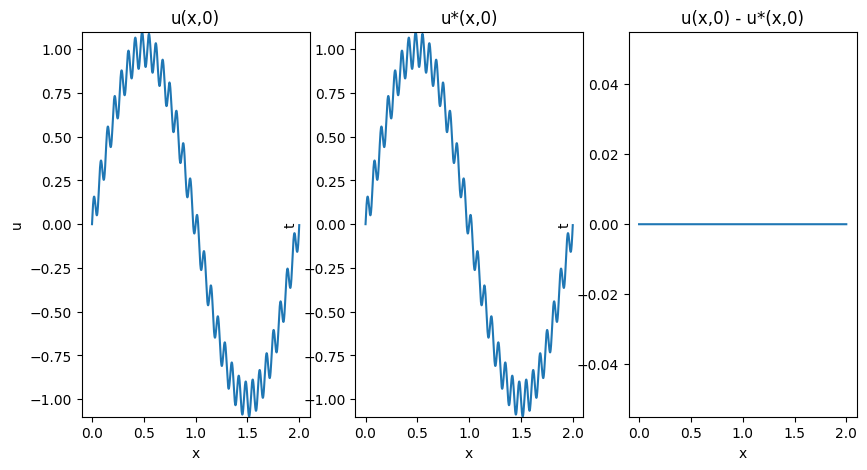

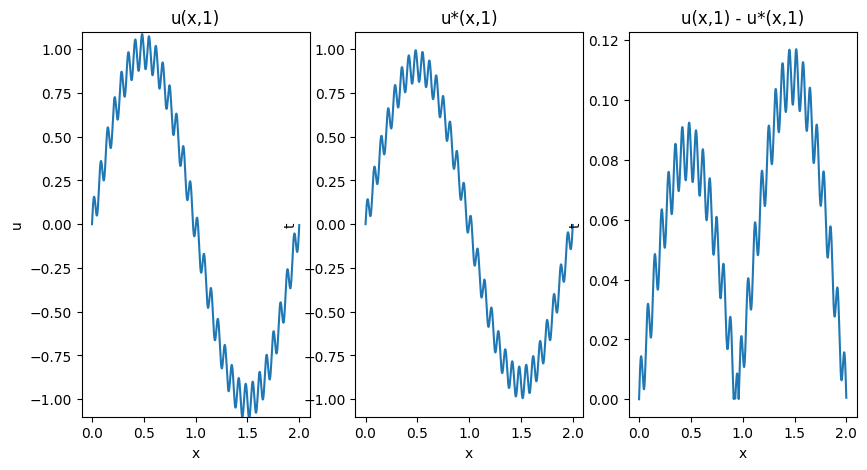

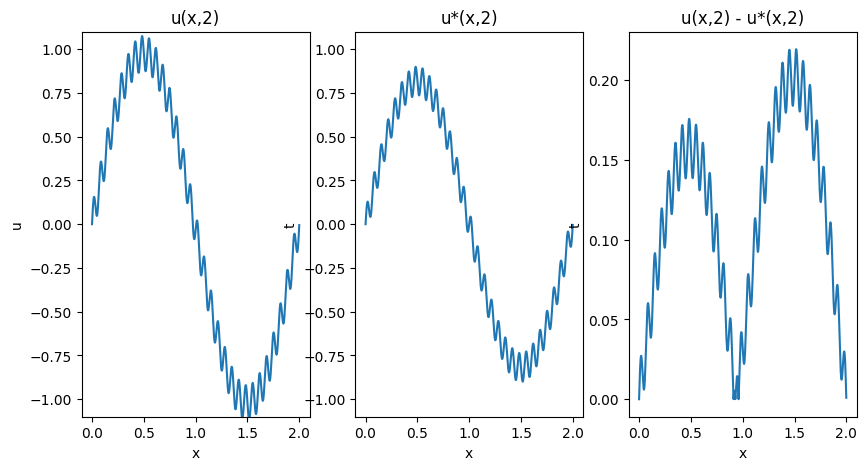

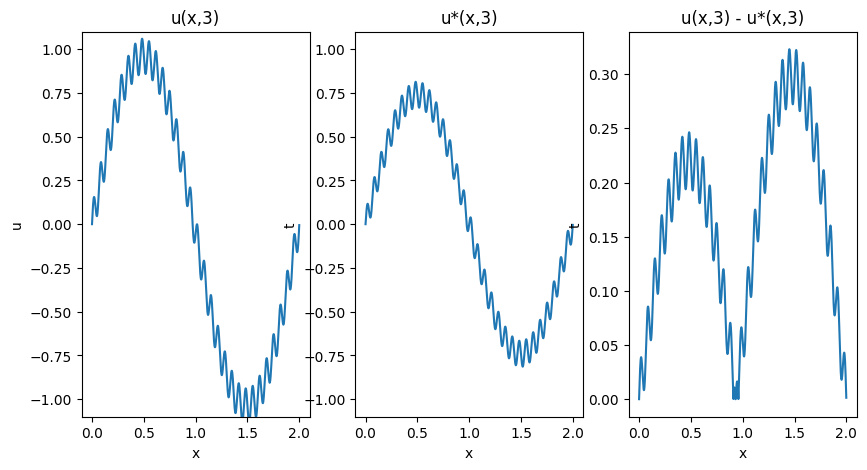

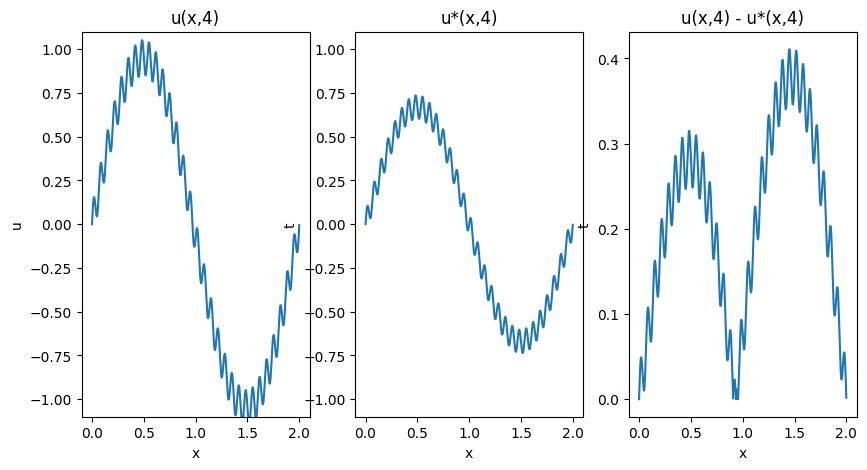

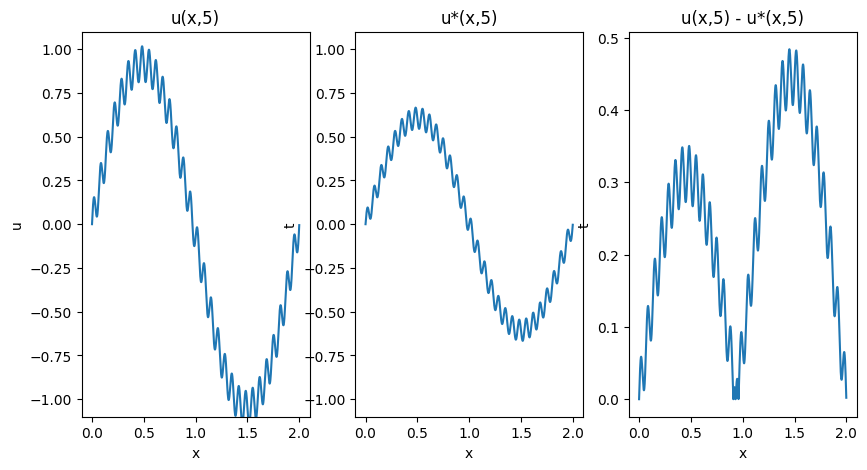

  2%|▏         | 1002/50000 [02:40<2:06:37,  6.45it/s]

epoch: 1000, learning_rate: 0.00776, loss: 9.22623 MSE: 0.01092 REL: 0.03436


  4%|▍         | 2001/50000 [05:20<2:24:15,  5.55it/s]

epoch: 2000, learning_rate: 0.00603, loss: 0.41529 MSE: 0.00959 REL: 0.03022


  6%|▌         | 3000/50000 [07:57<1:52:39,  6.95it/s]

epoch: 3000, learning_rate: 0.00468, loss: 0.05416 MSE: 0.00006 REL: 0.00020


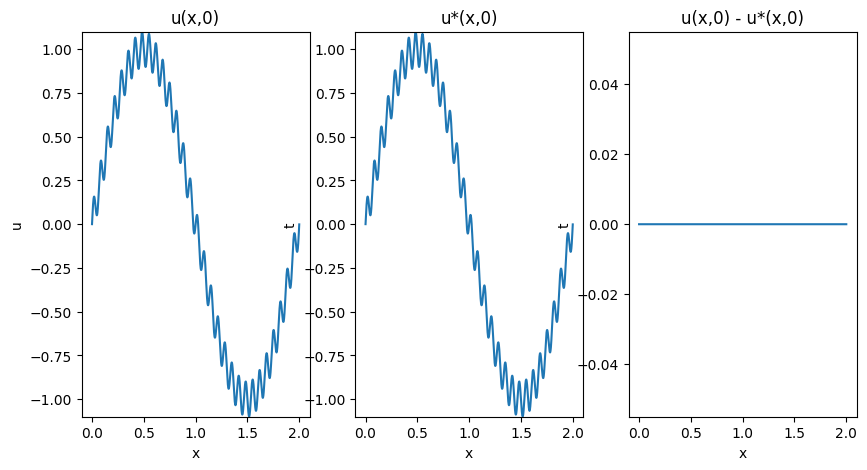

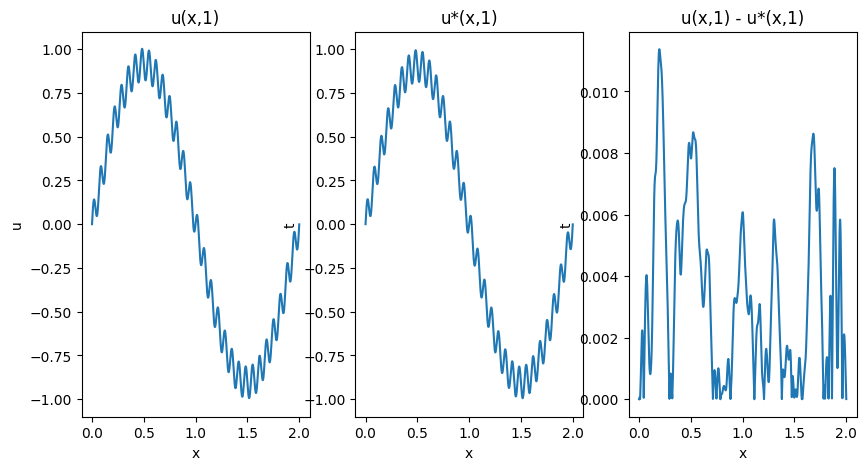

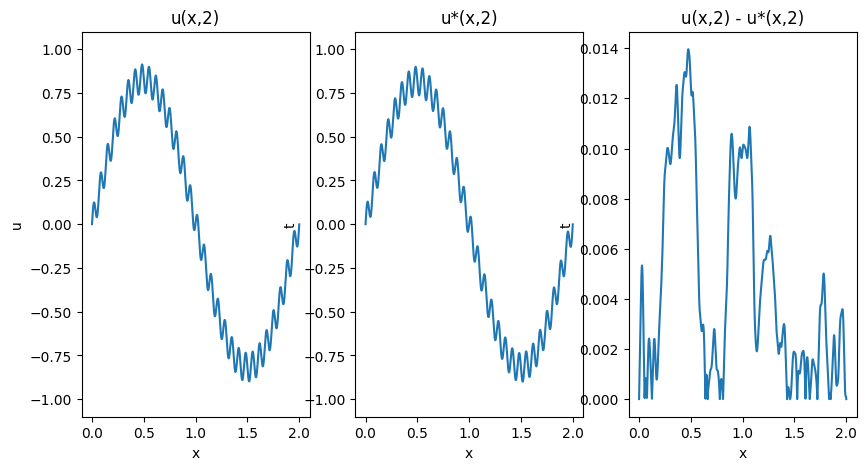

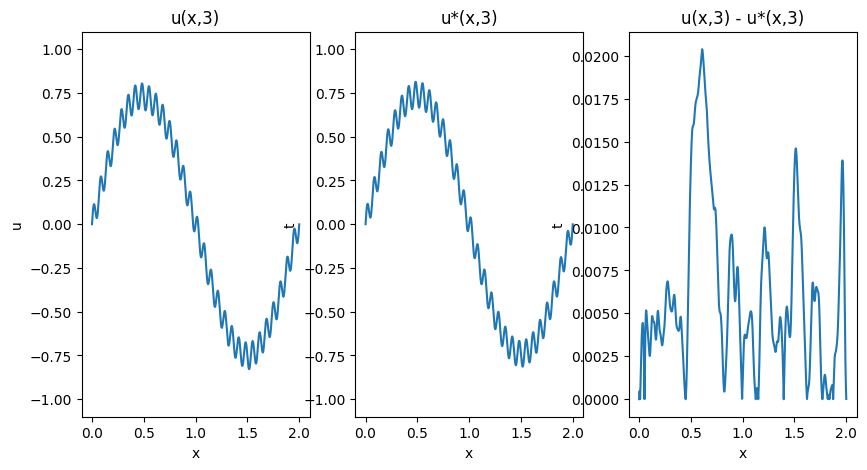

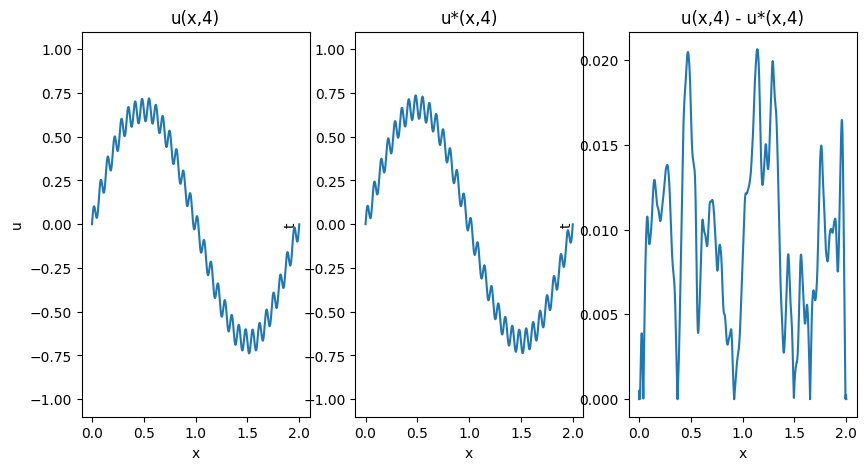

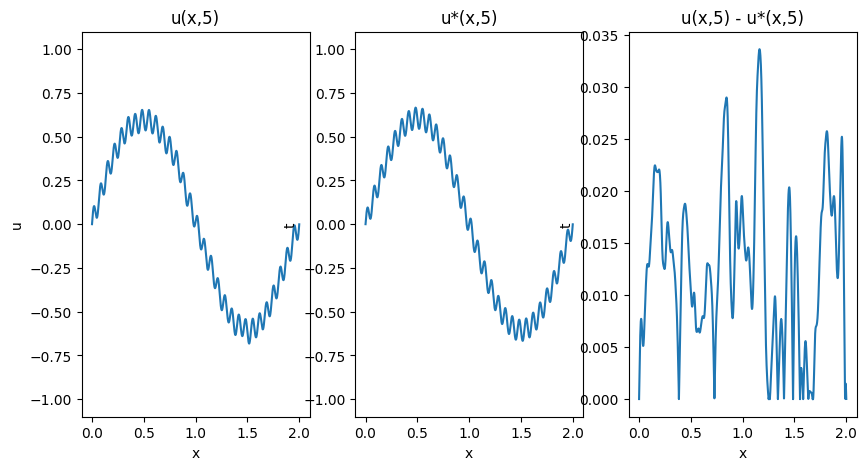

  7%|▋         | 3337/50000 [08:54<2:26:45,  5.30it/s]

In [ ]:
train(model, boundary, pde_residual, optimizer, scheduler, epoch,sampling_stragtegy="uniform")

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/model.pth")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/model.pth"))

In [ ]:
model.w.get_parameter('weight')

In [18]:
# # plot
# import matplotlib.pyplot as plt

# xt = generate_collocation_data(N_r, boundary,partial(gen_sample, strategy='Sobol'))
# xx,tt = torch.meshgrid(xt[:,0],xt[:,1])
# d = D(xt).unsqueeze(0).detach().cpu().numpy()
# plt.scatter(xt[:,0],xt[:,1], c=d)
# plt.colorbar()
# plt.xlabel('x')
# plt.ylabel('t')
# plt.title('D(x,t)')
# plt.show()

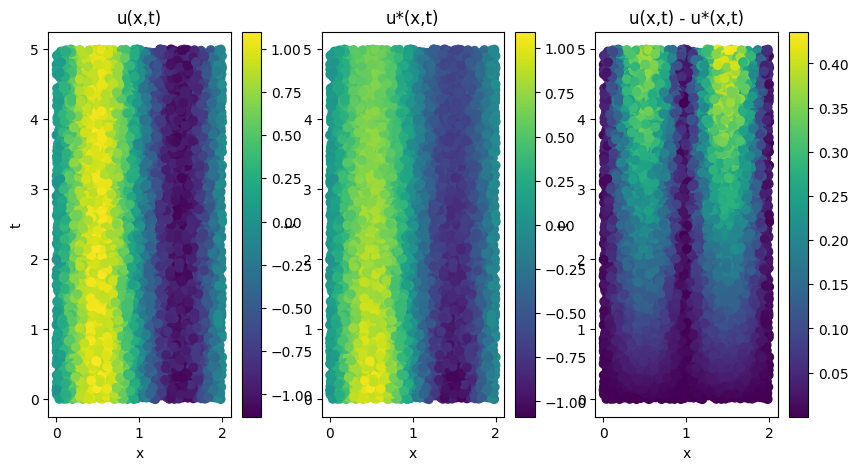

In [49]:
import matplotlib.pyplot as plt

with torch.no_grad():
  xt = generate_collocation_data(10_000, boundary,partial(gen_sample, strategy='uniform'))

  pred = model(xt.to(device)).detach().cpu()
  u_pred = (G(xt) + D(xt) * pred).numpy()
  u_true = U(xt).detach().cpu().numpy()
  abs_diff = np.abs(u_true-u_pred)

  fig = plt.figure(figsize=(10, 5))
  ax1 = fig.add_subplot(1,3,1)
  sc = ax1.scatter(xt[:,0],xt[:,1], c=u_pred)
  ax1.set_xlabel('x')
  ax1.set_ylabel('t')
  ax1.set_title('u(x,t)')

  plt.colorbar(sc, ax=ax1)
  # plt.colorbar(

  ax2 = fig.add_subplot(1,3,2)
  sc = ax2.scatter(xt[:,0],xt[:,1], c=u_true)
  # ax2.colorbar()
  ax2.set_xlabel('x')
  ax2.set_ylabel('t')
  ax2.set_title('u*(x,t)')

  plt.colorbar(sc, ax=ax2)

  ax3 = fig.add_subplot(1,3,3)

  sc = ax3.scatter(xt[:,0],xt[:,1], c=abs_diff)
  # ax3.colorbar()
  ax3.set_xlabel('x')
  ax3.set_ylabel('t')
  ax3.set_title('u(x,t) - u*(x,t)')

  plt.colorbar(sc, ax=ax3)
  plt.show()



In [54]:
def visualize(model):
  with torch.no_grad():
    xt_eval = generate_collocation_data(10_000, boundary,partial(gen_sample, strategy='uniform'))
    # sort
    xt_eval, _ = xt_eval.sort(dim=0)
    for ti in range(6):
      xt_eval[:,1] = ti * torch.ones(xt_eval.shape[0])

      pred = model(xt_eval.to(device)).detach().cpu()
      u_pred = (G(xt_eval) + D(xt_eval) * pred).numpy()
      u_true = U(xt_eval).detach().cpu().numpy()
      abs_diff = np.abs(u_true-u_pred)
      fig = plt.figure(figsize=(10, 5))


      ax1 = fig.add_subplot(1,3,1)
      ax1.plot(xt_eval[:,0], u_pred)
      ax1.set_xlabel('x')
      ax1.set_ylabel('u')
      ax1.set_ylim(-1.1,1.1)
      ax1.set_title(f'u(x,{ti})')

      #plt.colorbar(sc, ax=ax1)
      # plt.colorbar(

      ax2 = fig.add_subplot(1,3,2)
      ax2.plot(xt_eval[:,0], u_true)
      # ax2.colorbar()
      ax2.set_xlabel('x')
      ax2.set_ylabel('t')
      ax2.set_ylim(-1.1,1.1)
      ax2.set_title(f'u*(x,{ti})')


      ax3 = fig.add_subplot(1,3,3)

      ax3.plot(xt_eval[:,0], abs_diff)
      # ax3.colorbar()
      ax3.set_xlabel('x')
      ax3.set_ylabel('t')
      ax3.set_title(f'u(x,{ti}) - u*(x,{ti})')

      plt.show()